# JSON Serialization

In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser.waveforms import BlackmanWaveform
from pulser.devices import DigitalAnalogDevice

Often times, it is useful to import/export a given `Sequence` between different locations. To enable this, the `Sequence` object supports **serialization** and **deserialization** into JSON-formatted strings. This will work for any given `Sequence`. Take for example, this sequence that creates the Bell state $|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$:

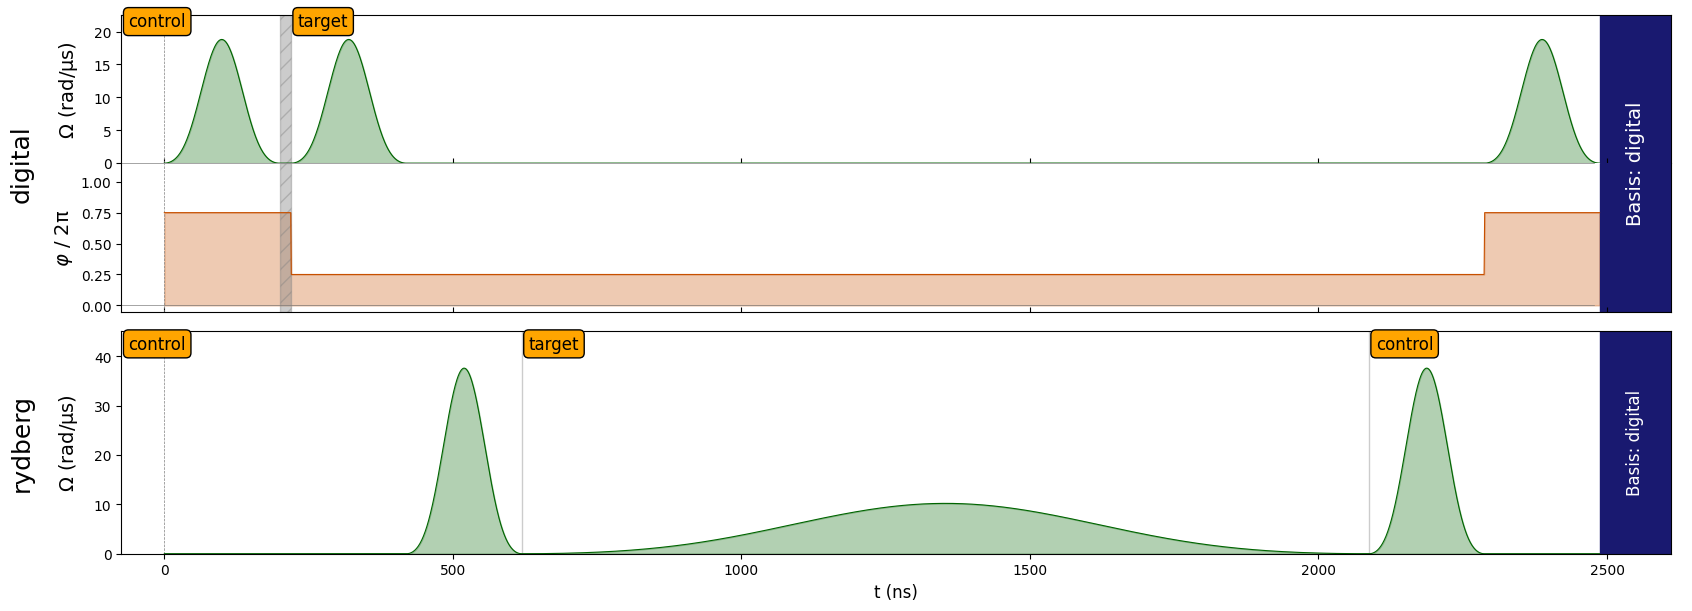

In [2]:
qubits = {"control": (-2, 0), "target": (2, 0)}
reg = Register(qubits)

seq = Sequence(reg, DigitalAnalogDevice)
pulse_time = seq.declare_variable("pulse_time", dtype=int)
seq.declare_channel("digital", "raman_local", initial_target="control")
seq.declare_channel("rydberg", "rydberg_local", initial_target="control")

half_pi_wf = BlackmanWaveform(pulse_time, area=np.pi / 2)

ry = Pulse.ConstantDetuning(amplitude=half_pi_wf, detuning=0, phase=-np.pi / 2)
ry_dag = Pulse.ConstantDetuning(
    amplitude=half_pi_wf, detuning=0, phase=np.pi / 2
)

seq.add(ry, "digital")
seq.target("target", "digital")
seq.add(ry_dag, "digital")

pi_wf = BlackmanWaveform(pulse_time, np.pi)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

max_val = DigitalAnalogDevice.rabi_from_blockade(9)
two_pi_wf = BlackmanWaveform.from_max_val(max_val, 2 * np.pi)
two_pi_pulse = Pulse.ConstantDetuning(two_pi_wf, 0, 0)

seq.align("digital", "rydberg")
seq.add(pi_pulse, "rydberg")
seq.target("target", "rydberg")
seq.add(two_pi_pulse, "rydberg")
seq.target("control", "rydberg")
seq.add(pi_pulse, "rydberg")

seq.align("digital", "rydberg")
seq.add(ry, "digital")
seq.measure("digital")
seq1 = seq.build(pulse_time=200)
seq1.draw()

## Serialize

To serialize, use `Sequence.to_abstract_repr()`:

In [3]:
s_readable = seq.to_abstract_repr(
    json_dumps_options={"indent": 1},
    seq_name="Sequence_with_defaults",
)
print(s_readable[:350], "...")

{
 "version": "1",
 "name": "Sequence_with_defaults",
 "register": [
  {
   "name": "control",
   "x": -2.0,
   "y": 0.0
  },
  {
   "name": "target",
   "x": 2.0,
   "y": 0.0
  }
 ],
 "channels": {
  "digital": "raman_local",
  "rydberg": "rydberg_local"
 },
 "variables": {
  "pulse_time": {
   "type": "int",
   "value": [
    0
   ]
  }
 },
 "ope ...


We can note that it is possible to provide optional parameters of `json.dumps` such as `indent` via a dictionnary in the argument `json_dumps_options`.

Providing optional arguments to `to_abstract_repr` defines default parameters in the JSON object (like the name of the sequence `seq_name`). This does not change the `Sequence` object in itself, as we'll see in the following part about deserialization.

## Deserialize

The generated strings contain all the necessary information for recreating the original sequence elsewhere (it could, for example, be saved to a file and then imported). To recover the sequence `seq` from `s_readable` (converted into JSON using `Sequence.to_abstract_repr()`), one should use `Sequence.from_abstract_repr()`. 

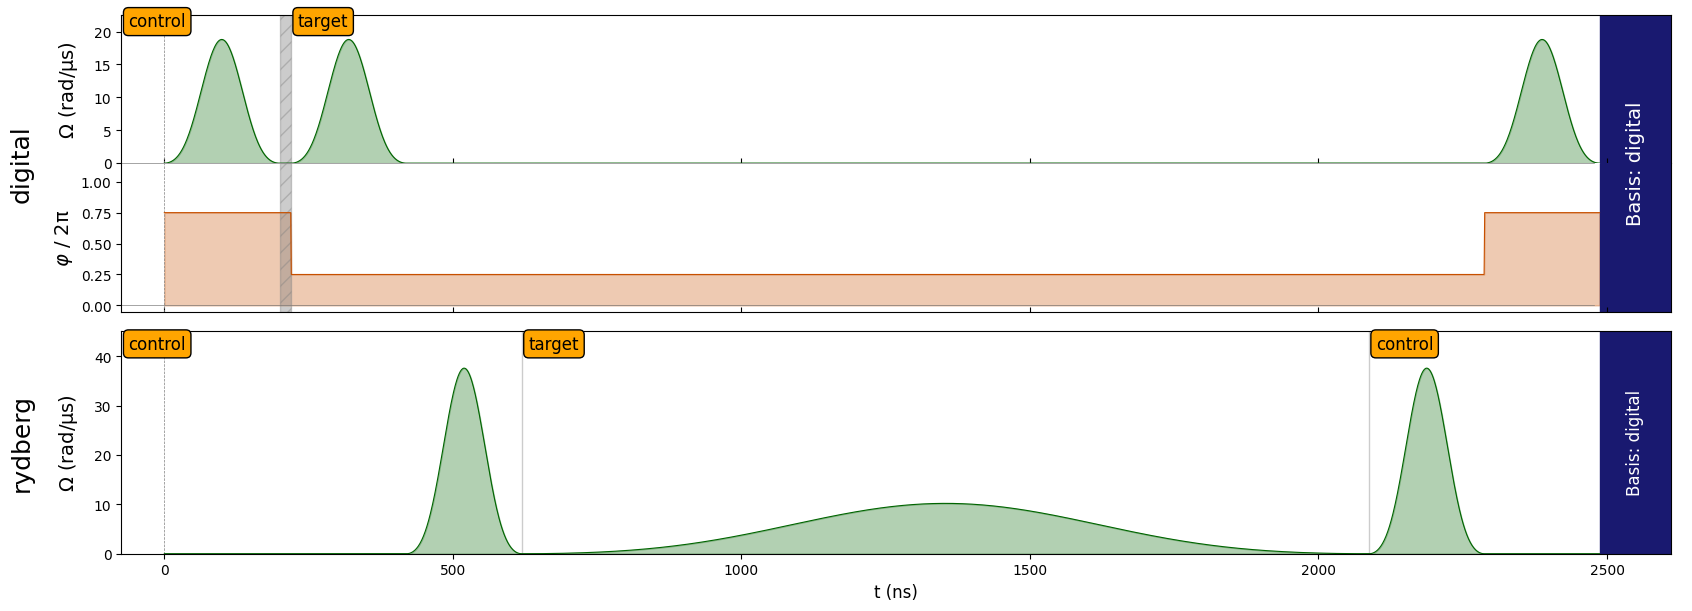

In [4]:
recovered_seq = Sequence.from_abstract_repr(s_readable)
recovered_seq.build(pulse_time=200).draw()